In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from keras import layers

from keras.metrics import Accuracy
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error

2025-01-30 16:35:42.093034: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-30 16:35:42.673691: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Load data if training is already done

In [3]:
data = np.load('../Results/lat.npz')
trainLat = data['xTrain']
testLat = data['xTest']

data = np.load('../Results/lon.npz')
trainLon = data['xTrain']
testLon = data['xTest']

data = np.load('../Results/trainScaled_pca.npz')
scaledXtrain_pca = data['xTrain']
yTrain = data['yTrain']

data = np.load('../Results/testScaled_pca.npz')
scaledXtest_pca = data['xTest']
yTest = data['yTest']

data = np.load('../Results/test.npz')
xTest = data['xTest']

### Pre-processing for training

In [4]:
f = "../Results/ML_Data_1HR.pkl"
data = pd.read_pickle(f)
data.head(3)

,fahrenheit,zscore,ndvi,lstLat,lstLon,stationID,tz,obsTimeUtc,obsTimeLocal,epoch,...,windchillLow,windchillAvg,heatindexHigh,heatindexLow,heatindexAvg,pressureMax,pressureMin,pressureTrend,precipRate,precipTotal
46460,61.156944,-1.895117,0.333525,39.343576,-76.710610,LGC,America/New_York,2023-08-31 14:59:00+00:00,2023-08-31 10:59:00,1693493940,...,20.5,21.0,21.1,20.5,20.8,1013.72,1012.80,0.52,0.0,0.0
118497,73.995790,1.305722,0.266438,39.307951,-76.592487,ARK,America/New_York,2023-08-31 14:59:00+00:00,2023-08-31 10:59:00,1693493940,...,22.0,22.6,22.7,21.6,22.1,1008.81,1007.89,0.62,0.0,0.0
163026,85.743195,1.034689,0.012722,39.243907,-76.530551,ARK,America/New_York,2023-08-23 14:59:00+00:00,2023-08-23 10:59:00,1692802740,...,24.8,25.6,26.9,24.5,25.4,1015.92,1015.31,-0.32,0.0,0.0


### Drop time, quality control, and location based columns

In [5]:
data['qcStatus'].value_counts()

qcStatus
1    669309
Name: count, dtype: int64

In [6]:
y = data['fahrenheit']

x = data.drop( columns=['fahrenheit','zscore','epoch','tz',
                        'stationID', 'obsTimeUtc', 'obsTimeLocal', 'qcStatus',
                        'bsecLat', 'bsecLon','precipRate','precipTotal'] )
x.shape

(669309, 31)

### Convert temperature to Celcius to match BSEC data

In [7]:
y = (y - 32.) * (5/9)

In [8]:
x.columns

Index(['ndvi', 'lstLat', 'lstLon', 'bsecDistance', 'solarRadiationHigh',
       'uvHigh', 'winddirAvg', 'humidityHigh', 'humidityLow', 'humidityAvg',
       'tempHigh', 'tempLow', 'tempAvg', 'windspeedHigh', 'windspeedLow',
       'windspeedAvg', 'windgustHigh', 'windgustLow', 'windgustAvg',
       'dewptHigh', 'dewptLow', 'dewptAvg', 'windchillHigh', 'windchillLow',
       'windchillAvg', 'heatindexHigh', 'heatindexLow', 'heatindexAvg',
       'pressureMax', 'pressureMin', 'pressureTrend'],
      dtype='object')

### Train/Test Split

In [81]:
x.shape

(669309, 31)

In [82]:
np.max( x['bsecDistance'] )

12.97432291059264

In [83]:
# stratify train/test split by distance to BSEC station

#  Create the bins
bins = np.arange(0, 14, 1)

# Save Y values in a new ndarray, broken down by the bins created above
binned = np.digitize( x['bsecDistance'], bins )

In [84]:
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.2, 
                                                random_state=42, stratify=binned)

In [85]:
xTrain.shape, yTrain.shape, xTest.shape, yTest.shape

((535447, 31), (535447,), (133862, 31), (133862,))

In [86]:
trainLat = xTrain['lstLat']
testLat = xTest['lstLat']

trainLon = xTrain['lstLon']
testLon = xTest['lstLon']

xTrain = xTrain.drop( columns=['lstLat','lstLon'] )
xTest = xTest.drop( columns=['lstLat','lstLon'] )

xTrain.shape, yTrain.shape, xTest.shape, yTest.shape

((535447, 29), (535447,), (133862, 29), (133862,))

In [87]:
scaler = StandardScaler()
scaler.fit(xTrain)
scaledXtrain = scaler.transform(xTrain)
scaledXtest = scaler.transform(xTest)

In [88]:
np.savez("../Results/lat", xTrain=trainLat, xTest=testLat)
np.savez("../Results/lon", xTrain=trainLon, xTest=testLon)

np.savez("../Results/train", xTrain=xTrain, yTrain=yTrain)
np.savez("../Results/test", xTest=xTest, yTest=yTest)
np.savez("../Results/trainScaled", xTrain=scaledXtrain, yTrain=yTrain)
np.savez("../Results/testScaled", xTest=scaledXtest, yTest=yTest)

### Principal Component Analysis for feature reduction

In [89]:
import pickle
from sklearn.decomposition import PCA

variance_threshold = 0.95
pca = PCA(n_components=variance_threshold, svd_solver='full')
scaledXtrain_pca = pca.fit_transform(scaledXtrain)
scaledXtest_pca = pca.fit_transform(scaledXtest)

print( X_reduced.shape, scaledXtrain.shape )

with open('./scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)
    
with open('./pca.pkl', 'wb') as file:
    pickle.dump(pca, file)

(535447, 7) (535447, 29)


In [90]:
np.savez("../Results/trainScaled_pca", xTrain=scaledXtrain_pca, yTrain=yTrain)
np.savez("../Results/testScaled_pca", xTest=scaledXtest_pca, yTest=yTest)

### Bayesian Neural Network

In [8]:
# Methods to calculate aleatoric and epistemic uncertainty based on 
# formulas from study by Valdenegro-Toro and Mori

# Aleatoric uncertainty is defined as the mean of variances
def getAleatoric( variances ):

    aleatoric = []
    n = len( variances[0] ) # total number predictions made
    nEnsemble = len( variances ) # number of ensemble members

    for i in range(n):
        var = []
        for j in range(nEnsemble):
            var.append(variances[j][i])
        aleatoric.append( np.mean(var) )

    return aleatoric

# Epistemic uncertainty is defined as the variance of means
def getEpistemic( means ):

    epistemic = []
    n = len( means[0] ) # total number predictions made
    nEnsemble = len( means ) # number of ensemble members

    for i in range(n):
        mns = []
        for j in range(nEnsemble):
            mns.append(means[j][i])
        m = np.mean( mns )
        mns = np.array(mns)
        diffs = mns**2 - m**2
        epistemic.append( np.mean(diffs) )

    return epistemic

In [9]:
# Custom Loss Function - Negative log Likelihood 
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [10]:
# Define the prior weight distribution as Normal of mean=0 and stddev=1
# The prior distribution is not trainable, as we fix its parameters
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

# Define variational posterior weight distribution as multivariate Gaussian
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [11]:
from keras import backend as K 

# Keras keeps models hanging around in memory. If we retrain a model, Keras will
# start from the previously concluded weight values. This resets everything.
K.clear_session()

In [12]:
inputs = tf.keras.Input( scaledXtrain_pca.shape[1] )

# first hidden layer
hidden1 = tfp.layers.DenseVariational(units=14,
                                      make_prior_fn=prior,
                                      make_posterior_fn=posterior,
                                      kl_weight=1/len(scaledXtrain_pca),
                                      activation='sigmoid')(inputs)

# second hidden layer
hidden2 = tfp.layers.DenseVariational(units=7,
                                      make_prior_fn=prior,
                                      make_posterior_fn=posterior,
                                      kl_weight=1/len(scaledXtrain_pca),
                                      activation='sigmoid')(hidden1)

# Define output layer with 2 parameters (mean and variance)
distribution_params = Dense(units=2)(hidden2)
outputs = tfp.layers.IndependentNormal(1)(distribution_params)

bnn = keras.Model(inputs=inputs, outputs=outputs)

bnn.compile(loss=nll, optimizer=keras.optimizers.RMSprop(learning_rate=0.001))

2025-01-30 16:36:39.967729: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5337 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:65:00.0, compute capability: 3.5


In [14]:
bnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_variational (DenseVar  (None, 14)               6440      
 iational)                                                       
                                                                 
 dense_variational_1 (DenseV  (None, 7)                5670      
 ariational)                                                     
                                                                 
 dense (Dense)               (None, 2)                 16        
                                                                 
 independent_normal (Indepen  ((None, 1),              0         
 dentNormal)                  (None, 1))                         
                                                             

In [97]:
history = bnn.fit( scaledXtrain_pca, yTrain, epochs=200, verbose=1, 
                     validation_split=0.2, batch_size=256 )

Epoch 1/200
1674/1674 [==============================] - 15s 8ms/step - loss: 54.5948 - val_loss: 4.0261
Epoch 2/200
1674/1674 [==============================] - 13s 8ms/step - loss: 3.3424 - val_loss: 2.7218
Epoch 3/200
1674/1674 [==============================] - 13s 8ms/step - loss: 2.5468 - val_loss: 2.4276
Epoch 4/200
1674/1674 [==============================] - 13s 8ms/step - loss: 2.3647 - val_loss: 2.3228
Epoch 5/200
1674/1674 [==============================] - 13s 8ms/step - loss: 2.2829 - val_loss: 2.2604
Epoch 6/200
1674/1674 [==============================] - 13s 8ms/step - loss: 2.2336 - val_loss: 2.2074
Epoch 7/200
1674/1674 [==============================] - 13s 8ms/step - loss: 2.1861 - val_loss: 2.1708
Epoch 8/200
1674/1674 [==============================] - 13s 8ms/step - loss: 2.1513 - val_loss: 2.1409
Epoch 9/200
1674/1674 [==============================] - 13s 8ms/step - loss: 2.1278 - val_loss: 2.1269
Epoch 10/200
1674/1674 [==============================] - 13s 8

1674/1674 [==============================] - 13s 8ms/step - loss: 1.8646 - val_loss: 1.8650
Epoch 80/200
1674/1674 [==============================] - 13s 8ms/step - loss: 1.8650 - val_loss: 1.8637
Epoch 81/200
1674/1674 [==============================] - 13s 8ms/step - loss: 1.8639 - val_loss: 1.8655
Epoch 82/200
1674/1674 [==============================] - 13s 8ms/step - loss: 1.8635 - val_loss: 1.8626
Epoch 83/200
1674/1674 [==============================] - 13s 8ms/step - loss: 1.8635 - val_loss: 1.8638
Epoch 84/200
1674/1674 [==============================] - 13s 8ms/step - loss: 1.8636 - val_loss: 1.8633
Epoch 85/200
1674/1674 [==============================] - 13s 8ms/step - loss: 1.8630 - val_loss: 1.8616
Epoch 86/200
1674/1674 [==============================] - 13s 8ms/step - loss: 1.8633 - val_loss: 1.8605
Epoch 87/200
1674/1674 [==============================] - 13s 8ms/step - loss: 1.8622 - val_loss: 1.8625
Epoch 88/200
1674/1674 [==============================] - 13s 8ms/st

In [100]:
# serialize weights to HDF5
bnn.save_weights("./bnn.h5")

In [13]:
bnn.load_weights("./bnn.h5")

(1.5, 4.0)

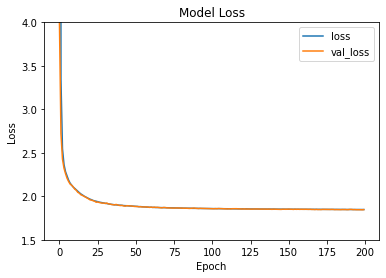

In [102]:
plt.plot( history.history['loss'], label="loss")
plt.plot( history.history['val_loss'], label="val_loss")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(1.5,4)

#### Compute Uncertainties

In [14]:
# Obtain 100 distributions for each test value
means = np.zeros( shape=(100,scaledXtest_pca.shape[0]) )
variances = np.zeros( shape=(100,scaledXtest_pca.shape[0]) )

for i in range(100):

    predictions = bnn(scaledXtest_pca)
    means[i,:] = np.array( predictions.mean()[:,0] )
    variances[i,:] = np.array( predictions.variance()[:,0] )

means.shape, variances.shape

((100, 133862), (100, 133862))

In [15]:
# Aleatoric Uncertainty
aleatoric = getAleatoric(variances)

#Epsitemic Uncertainty
epistemic = getEpistemic(means)

len(aleatoric), len(epistemic)

(133862, 133862)

In [16]:
aggregatedVar = np.array(aleatoric) + np.array(epistemic)
aggregatedVar.shape

(133862,)

#### Aggregated Predictions

In [17]:
aggregatedMean = np.mean( means, axis=0 )
aggregatedMean.shape

(133862,)

In [18]:
# Determine widths of 95% credible interval
import arviz as az

counter  = 0

count = 0
widths = []

n = len(yTest)

for i in range(n):
    
    samples = np.random.normal( loc=aggregatedMean[i], 
                               scale=np.sqrt(aggregatedVar[i]), size=1000)

    hdi = az.hdi(samples,hdi_prob=0.95)
    if( (yTest[i] >= hdi[0]) and (yTest[i] <= hdi[1])): count += 1
    widths.append(hdi[1]-hdi[0])
    
    if ( counter < 3 ): 
        print( hdi, testLat[i], testLon[i], 
               np.round(aggregatedMean[i],2), np.round(aggregatedVar[i],2), np.round(yTest[i],2), 
               np.round(epistemic[i],2), np.round(aleatoric[i],2) )
        counter += 1

count/n

[16.36206886 24.84230731] 39.24696470167119 -76.62413176325326 20.45 4.74 21.12 0.08 4.66
[24.52689705 30.49404944] 39.32871474694949 -76.57625155122828 27.46 2.34 25.9 0.08 2.26
[23.67284764 29.06848061] 39.36506692951514 -76.58647064102884 26.47 2.05 27.32 0.02 2.04


0.9509121333911043

### MAE

In [19]:
mean_absolute_error(yTest, aggregatedMean)

1.210446738729275

In [20]:
def cTof (c):
    return (c * 9/5) + 32

(40.0, 100.0)

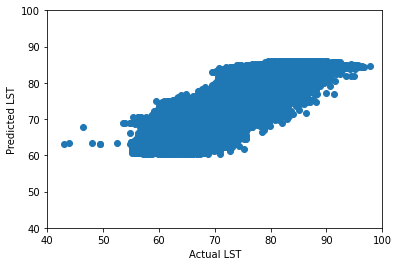

In [21]:
plt.scatter( cTof(yTest), cTof(aggregatedMean) )
plt.ylabel('Predicted LST')
plt.xlabel('Actual LST')
plt.xlim(40,100)
plt.ylim(40,100)

In [23]:
np.max(xTest[:,1]) # which column has a max of 12.9, which is the max BSEC distance?

12.96575991408698

(-15.0, 15.0)

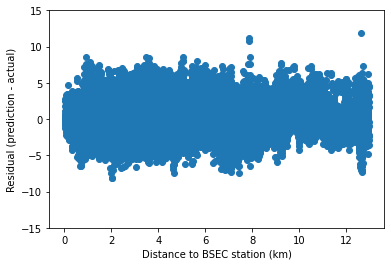

In [24]:
r = aggregatedMean - yTest
plt.scatter( xTest[:,1], r )
plt.xlabel('Distance to BSEC station (km)')
plt.ylabel('Residual (prediction - actual)')
plt.ylim(-15,15)

(-15.0, 15.0)

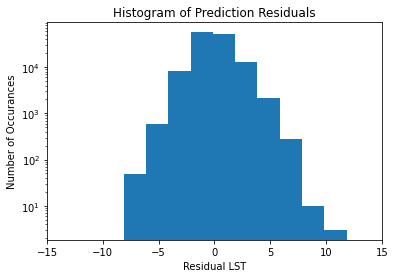

In [25]:
plt.hist(r)
plt.xlabel('Residual LST')
plt.ylabel('Number of Occurances')
plt.title('Histogram of Prediction Residuals')
plt.yscale('log')
plt.xlim(-15,15)

Text(0, 0.5, 'Latitude')

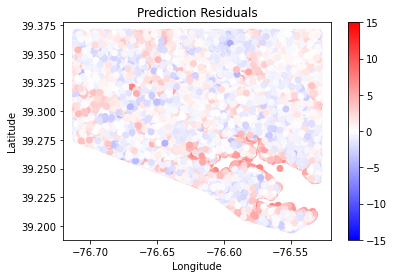

In [31]:
plt.scatter( testLon, testLat, c=r )
plt.set_cmap("bwr") # set colors to be blue to red
plt.colorbar()
plt.clim(-15,15)
plt.title('Prediction Residuals')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

#### Example predictions

Text(0, 0.5, 'Latitude')

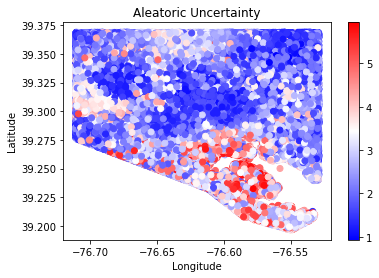

In [32]:
plt.scatter( testLon, testLat, c=aleatoric )
plt.colorbar()
plt.title('Aleatoric Uncertainty')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Text(0, 0.5, 'Latitude')

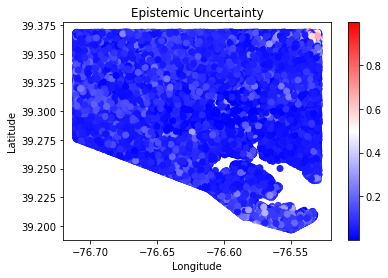

In [33]:
plt.scatter( testLon, testLat, c=epistemic )
plt.colorbar()
plt.title('Epistemic Uncertainty')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Text(0, 0.5, 'Latitude')

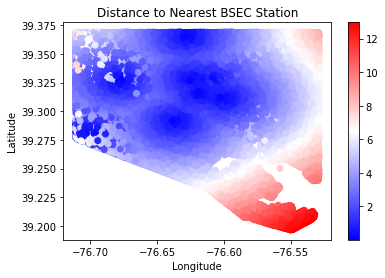

In [35]:
plt.scatter( testLon, testLat, c=xTest[:,1] )
plt.colorbar()
plt.title('Distance to Nearest BSEC Station')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [36]:
np.min(epistemic), np.max(epistemic)

(0.00013183298970488976, 0.9973677702660598)

In [39]:
# epistemic uncertainty thresholding

maes = []
percent = []

yTest = np.array(yTest)
mn, mx = np.min(epistemic), np.max(epistemic)
epiRange = np.linspace(mn, mx, 10)

for epi in epiRange:

    ix = np.where(epistemic <= epi)
    count = len(ix[0])
    subsetY = yTest[ix]
    subsetP = aggregatedMean[ix]
    mae = mean_absolute_error(subsetY, subsetP)
    mae = np.round(mae, 4)
    print("Epistemic Threshold:", np.round(epi,4), "MAE:", mae, ", % of Predictions Made:", count/len(y))
    maes.append(mae)
    percent.append(count/len(y))

Epistemic Threshold: 0.0001 MAE: 0.4537 , % of Predictions Made: 1.4940782209711807e-06
Epistemic Threshold: 0.1109 MAE: 1.1679 , % of Predictions Made: 0.16094808227589946
Epistemic Threshold: 0.2217 MAE: 1.2081 , % of Predictions Made: 0.19507282884288124
Epistemic Threshold: 0.3325 MAE: 1.2107 , % of Predictions Made: 0.19887226975881095
Epistemic Threshold: 0.4433 MAE: 1.2111 , % of Predictions Made: 0.19946392473431554
Epistemic Threshold: 0.5542 MAE: 1.2112 , % of Predictions Made: 0.19967458976347247
Epistemic Threshold: 0.665 MAE: 1.2112 , % of Predictions Made: 0.19981055088158087
Epistemic Threshold: 0.7758 MAE: 1.2111 , % of Predictions Made: 0.19985089099354708
Epistemic Threshold: 0.8866 MAE: 1.2111 , % of Predictions Made: 0.19992260674815368
Epistemic Threshold: 0.9974 MAE: 1.211 , % of Predictions Made: 0.20000029881564418


Text(0, 0.5, 'MAE')

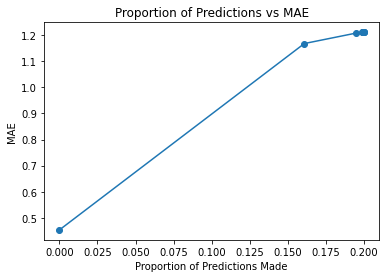

In [40]:
# Visual display of epistemic uncertainty thresholding
plt.plot(percent, maes,'-o')
plt.title("Proportion of Predictions vs MAE")
plt.xlabel("Proportion of Predictions Made")
plt.ylabel("MAE")
#plt.ylim(0.01,0.03)
#plt.colorbar()

In [45]:
hdi

array([21.263304, 25.98143 ], dtype=float32)

Text(0.5, 0, 'Width (Degrees)')

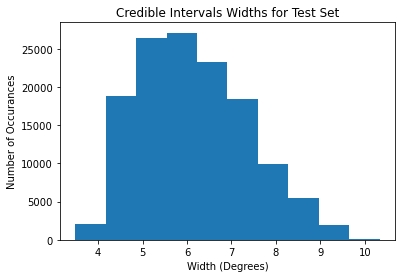

In [22]:
# Visualize widths of credible intervals
plt.hist(widths)
plt.title("Credible Intervals Widths for Test Set")
plt.ylabel('Number of Occurances')
plt.xlabel('Width (Degrees)')

Text(0, 0.5, 'Latitude')

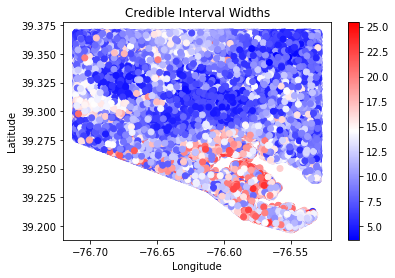

In [42]:
plt.scatter( testLon, testLat, c=widths )
plt.colorbar()
plt.title('Credible Interval Widths')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

### Out of Distribution Examples

In [20]:
# harbor area
harbor = data[ (data['lstLat'] > 39.225) & (data['lstLat'] < 39.250) &
               (data['lstLon'] > -76.6) & (data['lstLon'] < -76.57) ]

harbor.shape

(25826, 43)

In [21]:
harbor.columns

Index(['fahrenheit', 'zscore', 'ndvi', 'lstLat', 'lstLon', 'stationID', 'tz',
       'obsTimeUtc', 'obsTimeLocal', 'epoch', 'bsecLat', 'bsecLon',
       'bsecDistance', 'solarRadiationHigh', 'uvHigh', 'winddirAvg',
       'humidityHigh', 'humidityLow', 'humidityAvg', 'qcStatus', 'tempHigh',
       'tempLow', 'tempAvg', 'windspeedHigh', 'windspeedLow', 'windspeedAvg',
       'windgustHigh', 'windgustLow', 'windgustAvg', 'dewptHigh', 'dewptLow',
       'dewptAvg', 'windchillHigh', 'windchillLow', 'windchillAvg',
       'heatindexHigh', 'heatindexLow', 'heatindexAvg', 'pressureMax',
       'pressureMin', 'pressureTrend', 'precipRate', 'precipTotal'],
      dtype='object')

In [22]:
np.max( harbor.tempAvg )

28.6

In [23]:
# average wind speed - 10
# average wind gust - 16
# ndvi - 0.8
#harbor.loc[:, 'windspeedAvg'] = 10
#harbor.loc[:, 'windgustAvg'] = 16
harbor.loc[:, 'tempAvg'] = 38

In [24]:
import pickle

with open('./scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=7, svd_solver='full')

harborLat = harbor['lstLat']
harborLon = harbor['lstLon']

harbor = harbor.drop( columns=['fahrenheit','zscore','epoch','tz',
                        'stationID', 'obsTimeUtc', 'obsTimeLocal', 'qcStatus',
                        'bsecLat', 'bsecLon','precipRate','precipTotal', 'lstLat', 'lstLon'] )

harborScaled = scaler.transform(harbor)
print( harborScaled.shape )

harborPCA = pca.fit_transform(harborScaled)
print( harborPCA.shape )

(25826, 29)
(25826, 7)


In [26]:
# Obtain 100 distributions for each test value
meansOOD = np.zeros( shape=(100,harborPCA.shape[0]) )
variancesOOD = np.zeros( shape=(100,harborPCA.shape[0]) )

for i in range(100):

    predictionsOOD = bnn(harborPCA)
    meansOOD[i,:] = np.array( predictionsOOD.mean()[:,0] )
    variancesOOD[i,:] = np.array( predictionsOOD.variance()[:,0] )

meansOOD.shape, variancesOOD.shape

((100, 25826), (100, 25826))

In [27]:
# Aleatoric Uncertainty
aleatoricOOD = getAleatoric(variancesOOD)

#Epsitemic Uncertainty
epistemicOOD = getEpistemic(meansOOD)

len(aleatoricOOD), len(epistemicOOD)

(25826, 25826)

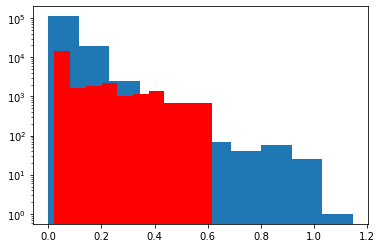

In [112]:
plt.hist(epistemic)
plt.hist(epistemicOOD, color='red')
plt.yscale('log')

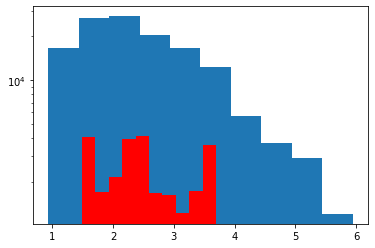

In [113]:
plt.hist(aleatoric)
plt.hist(aleatoricOOD, color='red')
plt.yscale('log')

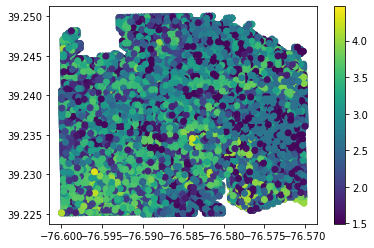

In [138]:
totalError = np.array(aleatoricOOD) + np.array(epistemicOOD)
plt.scatter( harborLon, harborLat, c=totalError )
plt.colorbar()

Text(0, 0.5, 'Latitude')

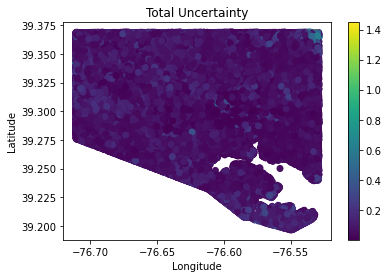

In [30]:
total = np.array(epistemic) + np.array(aleatoric)
plt.scatter( testLon, testLat, c=epistemic )
plt.colorbar()
plt.title('Total Uncertainty')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

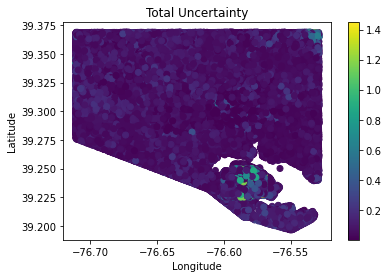

In [29]:
total = np.array(epistemic) + np.array(aleatoric)
plt.scatter( testLon, testLat, c=epistemic )
plt.colorbar()
plt.title('Total Uncertainty')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter( harborLon, harborLat, c=epistemicOOD )

In [31]:
ix = np.where( np.array(aleatoric) < 1 )[0]
print(len(ix))
testLat[ix[0:100]], testLon[ix[0:100]]

265


(array([39.35680085, 39.3496395 , 39.36878102, 39.35972664, 39.35656178,
        39.34996521, 39.34509718, 39.35567225, 39.35883179, 39.34826058,
        39.34647073, 39.34997444, 39.35959147, 39.35272417, 39.35441414,
        39.34879175, 39.34057341, 39.35133019, 39.35988489, 39.35125622,
        39.35985241, 39.34864748, 39.34955135, 39.34819092, 39.35457751,
        39.34440777, 39.34437054, 39.34437519, 39.34023315, 39.35770918,
        39.35788175, 39.35308286, 39.35702441, 39.35134863, 39.34983087,
        39.34559079, 39.34111852, 39.35183831, 39.35257027, 39.35988025,
        39.34992824, 39.34832075, 39.34788811, 39.35803042, 39.35062294,
        39.34397864, 39.34393233, 39.3533991 , 39.35558446, 39.34994673,
        39.34584708, 39.3414353 , 39.35444792, 39.34482167, 39.35971181,
        39.35203909, 39.35995432, 39.35724787, 39.34712862, 39.35662298,
        39.35040383, 39.35407996, 39.34868947, 39.3528915 , 39.35277543,
        39.35072034, 39.3567121 , 39.35210854, 39.3

In [32]:
ne = data[ (data['lstLat'] > 39.352) & (data['lstLat'] < 39.356) &
               (data['lstLon'] > -76.58) & (data['lstLon'] < -76.542) ]

ne.shape

(4863, 43)

In [33]:
neLat = ne['lstLat']
neLon = ne['lstLon']

ne = ne.drop( columns=['fahrenheit','zscore','epoch','tz',
                        'stationID', 'obsTimeUtc', 'obsTimeLocal', 'qcStatus',
                        'bsecLat', 'bsecLon','precipRate','precipTotal', 'lstLat', 'lstLon'] )

ne.loc[:, 'tempAvg'] = 38

neScaled = scaler.transform(ne)
print( neScaled.shape )

nePCA = pca.fit_transform(neScaled)
print( nePCA.shape )

# Obtain 100 distributions for each test value
meansOOD = np.zeros( shape=(100,nePCA.shape[0]) )
variancesOOD = np.zeros( shape=(100,nePCA.shape[0]) )

for i in range(100):

    predictionsOOD = bnn(nePCA)
    meansOOD[i,:] = np.array( predictionsOOD.mean()[:,0] )
    variancesOOD[i,:] = np.array( predictionsOOD.variance()[:,0] )

meansOOD.shape, variancesOOD.shape

# Aleatoric Uncertainty
aleatoricOOD = getAleatoric(variancesOOD)

#Epsitemic Uncertainty
epistemicOOD = getEpistemic(meansOOD)

len(aleatoricOOD), len(epistemicOOD)

(4863, 29)
(4863, 7)


(4863, 4863)

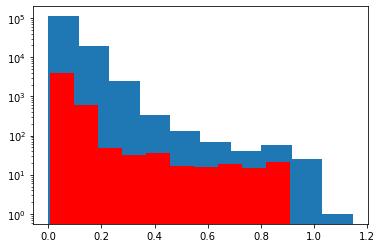

In [120]:
plt.hist(epistemic)
plt.hist(epistemicOOD, color='red')
plt.yscale('log')

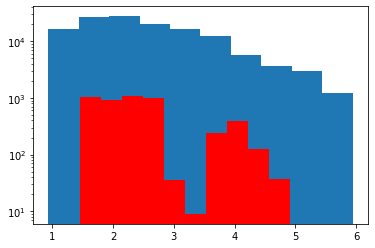

In [121]:
plt.hist(aleatoric)
plt.hist(aleatoricOOD, color='red')
plt.yscale('log')

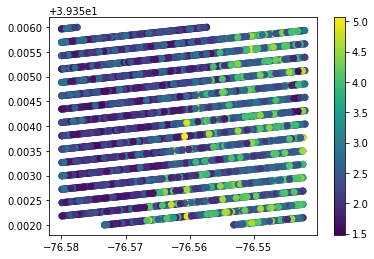

In [122]:
totalError = np.array(aleatoricOOD) + np.array(epistemicOOD)
plt.scatter( neLon, neLat, c=totalError )
plt.colorbar()

Text(0, 0.5, 'Latitude')

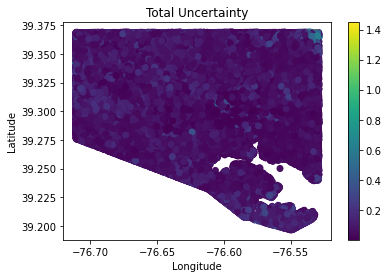

In [34]:
total = np.array(epistemic) + np.array(aleatoric)
plt.scatter( testLon, testLat, c=epistemic )
plt.colorbar()
plt.title('Total Uncertainty')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

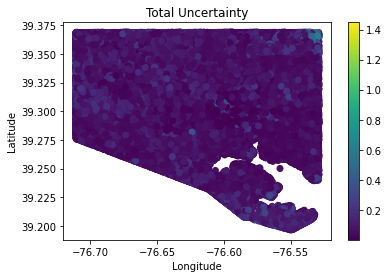

In [35]:
total = np.array(epistemic) + np.array(aleatoric)
plt.scatter( testLon, testLat, c=epistemic )
plt.colorbar()
plt.title('Total Uncertainty')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.scatter( neLon, neLat, c=epistemicOOD )